## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (184 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

# Generate Dataset

- Train, Validation, Test

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def make_dir(base_path, level):
    level_dir = f'{base_path}level{level}'
    if not os.path.exists(level_dir):
        os.mkdir(level_dir)
    train_image_dir = os.path.join(level_dir,'train_image/')
    train_mask_dir = os.path.join(level_dir,'train_mask/')

    val_image_dir = os.path.join(level_dir,'val_image/')
    val_mask_dir = os.path.join(level_dir,'val_mask/')

    test_image_dir = os.path.join(level_dir,'test_image/')
    test_mask_dir = os.path.join(level_dir,'test_mask/')

    if not os.path.exists(train_image_dir):
        os.mkdir(train_image_dir)
    if not os.path.exists(train_mask_dir):
        os.mkdir(train_mask_dir)
    if not os.path.exists(val_image_dir):
        os.mkdir(val_image_dir)
    if not os.path.exists(val_mask_dir):
        os.mkdir(val_mask_dir)    
    if not os.path.exists(test_image_dir):
        os.mkdir(test_image_dir)
    if not os.path.exists(test_mask_dir):
        os.mkdir(test_mask_dir)
    return(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir)

In [5]:
base_path = '/content/'
train_image_dir5, train_mask_dir5, val_image_dir5, val_mask_dir5, test_image_dir5, test_mask_dir5 = make_dir(base_path, level = 5)
train_image_dir4, train_mask_dir4, val_image_dir4, val_mask_dir4, test_image_dir4, test_mask_dir4 = make_dir(base_path, level = 4)
train_image_dir3, train_mask_dir3, val_image_dir3, val_mask_dir3, test_image_dir3, test_mask_dir3 = make_dir(base_path, level = 3)

In [6]:
# create a folder called 'Applied Deep Learning' in the Google Drive

!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/train_mask.zip' -d /content/level4/train_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/train_image.zip' -d /content/level4/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/val_mask.zip' -d /content/level4/val_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/val_image.zip' -d /content/level4/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/test_mask.zip' -d /content/level4/test_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/test_image.zip' -d /content/level4/test_image/

!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/train_mask.zip' -d /content/level5/train_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/train_image.zip' -d /content/level5/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/val_mask.zip' -d /content/level5/val_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/val_image.zip' -d /content/level5/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/test_mask.zip' -d /content/level5/test_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/test_image.zip' -d /content/level5/test_image/

!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/train_mask.zip' -d /content/level3/train_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/train_image.zip' -d /content/level3/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/val_mask.zip' -d /content/level3/val_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/val_image.zip' -d /content/level3/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/test_mask.zip' -d /content/level3/test_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/test_image.zip' -d /content/level3/test_image/

In [7]:
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level4/level4_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level4/level4_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level4/level4_test_data.txt' /content/

!cp '/content/drive/MyDrive/Applied Deep Learning/project/level5/level5_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level5/level5_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level5/level5_test_data.txt' /content/

!cp '/content/drive/MyDrive/Applied Deep Learning/project/level3/level3_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level3/level3_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level3/level3_test_data.txt' /content/

In [8]:
IMG_SIZE = 299
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data generator
def data_generator(train_image_dir, val_image_dir, test_image_dir):
    train_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    # train set
    train_generator = train_datagen.flow_from_directory(
        train_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True
    )
    validation_generator = test_datagen.flow_from_directory(
        val_image_dir, 
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True
    )

    for data_batch, labels_batch in train_generator:
        print('Train data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break

    for data_batch, labels_batch in validation_generator:
        print('\n')
        print('Validation data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    # test set
    test_generator = test_datagen.flow_from_directory(
        test_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True
    )
    return(train_generator, validation_generator, test_generator)

# data generator with augmentation
def data_generator_aug(train_image_dir, val_image_dir, test_image_dir):
    # train set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        # zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    # train set
    train_generator = train_datagen.flow_from_directory(
        train_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True
    )
    validation_generator = test_datagen.flow_from_directory(
        val_image_dir, 
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True
    )

    for data_batch, labels_batch in train_generator:
        print('Train data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break

    for data_batch, labels_batch in validation_generator:
        print('\n')
        print('Validation data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    # test set
    test_generator = test_datagen.flow_from_directory(
        test_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True
    )
    return(train_generator, validation_generator, test_generator)

In [9]:
# train_generator, validation_generator, test_generator = data_generator(train_image_dir4, val_image_dir4, test_image_dir4)
train_generator, validation_generator, test_generator = data_generator_aug(train_image_dir4, val_image_dir4, test_image_dir4)

# train_generator, validation_generator, test_generator = data_generator(train_image_dir5, val_image_dir5, test_image_dir5)
# train_generator_aug, validation_generator, test_generator = data_generator_aug(train_image_dir5, val_image_dir5, test_image_dir5)

Found 6954 images belonging to 2 classes.
Found 1578 images belonging to 2 classes.
Train data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


Validation data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)
Found 1341 images belonging to 2 classes.


In [15]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu',
                                 input_shape = (IMG_SIZE, IMG_SIZE, 3)))
model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
# model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = validation_generator
)

Epoch 1/5
218/218 [==============================] - 151s 660ms/step - loss: 6.1744 - accuracy: 0.8510 - val_loss: 0.1345 - val_accuracy: 0.9759
Epoch 2/5
218/218 [==============================] - 139s 637ms/step - loss: 0.2795 - accuracy: 0.9004 - val_loss: 0.1471 - val_accuracy: 0.9759
Epoch 3/5
218/218 [==============================] - 134s 615ms/step - loss: 0.2749 - accuracy: 0.9030 - val_loss: 0.1313 - val_accuracy: 0.9759
Epoch 4/5
218/218 [==============================] - 135s 619ms/step - loss: 0.2663 - accuracy: 0.9090 - val_loss: 0.1452 - val_accuracy: 0.9759
Epoch 5/5
218/218 [==============================] - 133s 610ms/step - loss: 0.2714 - accuracy: 0.9054 - val_loss: 0.1969 - val_accuracy: 0.9759


In [17]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 4s 105ms/step - loss: 2.5873 - accuracy: 0.6264
test loss, test acc: [2.5872890949249268, 0.6263982057571411]


In [18]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.labels

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       840
           1       0.00      0.00      0.00       501

    accuracy                           0.63      1341
   macro avg       0.31      0.50      0.39      1341
weighted avg       0.39      0.63      0.48      1341



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# VGG16 

In [20]:
IMG_SIZE = 299
base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    pooling = None,
    classes = 2,
    classifier_activation = 'softmax',
)

# do not update the pretrained weights during training
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# build a model to use the pretrained base
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


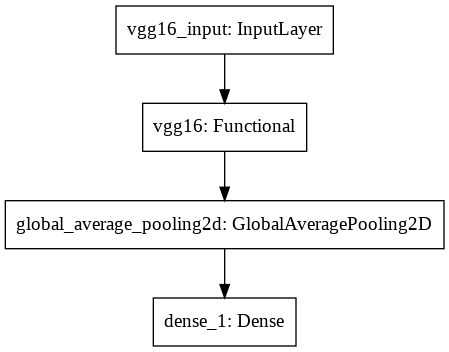

In [21]:
tf.keras.utils.plot_model(model)

In [31]:
if not os.path.exists('/content/checkpoint'):
  os.mkdir('/content/checkpoint')
if not os.path.exists('/content/checkpoint/VGG'):
  os.mkdir('/content/checkpoint/VGG')
vgg_checkpoint_path = '/content/checkpoint/VGG/weights-improvement-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'
vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(vgg_checkpoint_path, 
                                                               monitor='val_loss', 
                                                               save_best_only=True, 
                                                               mode='auto')

In [ ]:
vgg_early_stop_callback = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=10
                          )

In [23]:
epochs = 20
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks=[vgg_early_stop_callback, vgg_checkpoint_callback]
)

Epoch 1/20
218/218 [==============================] - 165s 746ms/step - loss: 0.3928 - accuracy: 0.8373 - val_loss: 0.1702 - val_accuracy: 0.9759
Epoch 2/20
218/218 [==============================] - 161s 739ms/step - loss: 0.3137 - accuracy: 0.8870 - val_loss: 0.1393 - val_accuracy: 0.9759
Epoch 3/20
218/218 [==============================] - 160s 735ms/step - loss: 0.2944 - accuracy: 0.8892 - val_loss: 0.1562 - val_accuracy: 0.9759
Epoch 4/20
218/218 [==============================] - 157s 721ms/step - loss: 0.2787 - accuracy: 0.8934 - val_loss: 0.1435 - val_accuracy: 0.9759
Epoch 5/20
218/218 [==============================] - 158s 725ms/step - loss: 0.2685 - accuracy: 0.8909 - val_loss: 0.1246 - val_accuracy: 0.9759
Epoch 6/20
218/218 [==============================] - 158s 723ms/step - loss: 0.2682 - accuracy: 0.8917 - val_loss: 0.1365 - val_accuracy: 0.9747
Epoch 7/20
218/218 [==============================] - 159s 727ms/step - loss: 0.2589 - accuracy: 0.8977 - val_loss: 0.1288 -

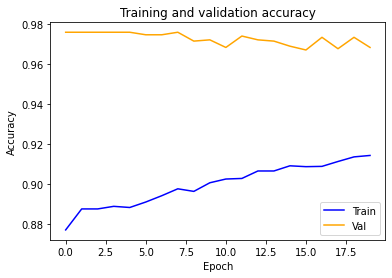

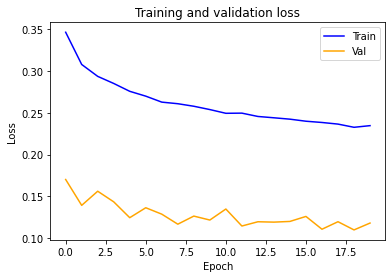

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.title('Training and validation accuracy')
plt.plot(range(epochs), acc, color='blue', label='Train')
plt.plot(range(epochs), val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(epochs), loss, color='blue', label='Train')
plt.plot(range(epochs), val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [25]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 12s 281ms/step - loss: 0.7005 - accuracy: 0.6294
test loss, test acc: [0.7005316019058228, 0.6293810606002808]


In [27]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.labels

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.96      0.76       840
           1       0.39      0.04      0.08       501

    accuracy                           0.62      1341
   macro avg       0.51      0.50      0.42      1341
weighted avg       0.54      0.62      0.50      1341



## Fine Tuning

In [33]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 10
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=validation_generator,
                    callbacks=[vgg_early_stop_callback, vgg_checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
218/218 [==============================] - 216s 973ms/step - loss: 0.2444 - accuracy: 0.9074 - val_loss: 0.1142 - val_accuracy: 0.9721
Epoch 2/10
218/218 [==============================] - 210s 959ms/step - loss: 0.1424 - accuracy: 0.9510 - val_loss: 0.0916 - val_accuracy: 0.9772
Epoch 3/10
218/218 [==============================] - 209s 957ms/step - loss: 0.

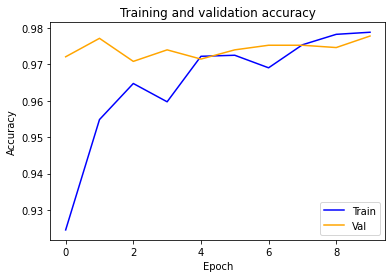

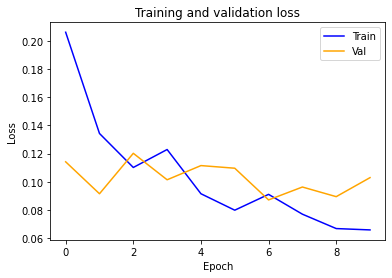

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.title('Training and validation accuracy')
plt.plot(range(epochs), acc, color='blue', label='Train')
plt.plot(range(epochs), val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(epochs), loss, color='blue', label='Train')
plt.plot(range(epochs), val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [35]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 10s 241ms/step - loss: 0.6635 - accuracy: 0.8441
test loss, test acc: [0.663512110710144, 0.8441461324691772]


In [37]:
predictions = model.predict(test_generator)
tumor_prob = predictions[:,1]
y_pred = np.round(tumor_prob)
# y_pred = np.argmax(predictions, axis=-1)
y_true = test_generator.labels

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.79      0.70       840
           1       0.38      0.22      0.28       501

    accuracy                           0.58      1341
   macro avg       0.51      0.50      0.49      1341
weighted avg       0.54      0.58      0.54      1341



# InceptionV3

- with data augmentation

In [13]:
if not os.path.exists('/content/checkpoint'):
  os.mkdir('/content/checkpoint')
if not os.path.exists('/content/checkpoint/Inception'):
  os.mkdir('/content/checkpoint/Inception')
inception_checkpoint_path = '/content/checkpoint/Inception/weights-improvement-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'
inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(inception_checkpoint_path, 
                                                               monitor='val_loss', 
                                                               save_best_only=True, 
                                                               mode='auto')

In [ ]:
inception_early_stop_callback = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=10
                          )

In [14]:
IMG_SIZE = 299

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                           weights='imagenet',
                                           input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

inception_model = tf.keras.models.Sequential()
inception_model.add(base_model)
inception_model.add(tf.keras.layers.GlobalAveragePooling2D())
inception_model.add(tf.keras.layers.Dense(256, activation='relu'))
inception_model.add(tf.keras.layers.Dropout(rate = 0.4))
inception_model.add(tf.keras.layers.Dense(128, activation='relu'))
inception_model.add(tf.keras.layers.Dense(2, activation='softmax'))




inception_model.summary()

inception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss = 'sparse_categorical_crossentropy',
                        metrics = ['accuracy'])

87916544/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 22,360,482
Trainable params: 557,698
Non-tr

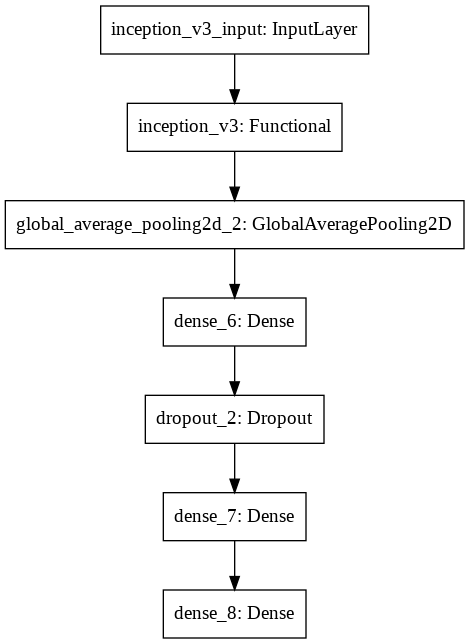

In [49]:
tf.keras.utils.plot_model(inception_model)

In [15]:
epochs = 20
inception_history = inception_model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks=[inception_early_stop_callback, inception_checkpoint_callback]
)

Epoch 1/20
218/218 [==============================] - 166s 711ms/step - loss: 0.3973 - accuracy: 0.8652 - val_loss: 0.1387 - val_accuracy: 0.9759
Epoch 2/20
218/218 [==============================] - 145s 665ms/step - loss: 0.2752 - accuracy: 0.8989 - val_loss: 0.1200 - val_accuracy: 0.9759
Epoch 3/20
218/218 [==============================] - 142s 653ms/step - loss: 0.2770 - accuracy: 0.8879 - val_loss: 0.1226 - val_accuracy: 0.9766
Epoch 4/20
218/218 [==============================] - 142s 650ms/step - loss: 0.2725 - accuracy: 0.8884 - val_loss: 0.1400 - val_accuracy: 0.9766
Epoch 5/20
218/218 [==============================] - 141s 648ms/step - loss: 0.2651 - accuracy: 0.8979 - val_loss: 0.1320 - val_accuracy: 0.9715
Epoch 6/20
218/218 [==============================] - 141s 649ms/step - loss: 0.2301 - accuracy: 0.9099 - val_loss: 0.1279 - val_accuracy: 0.9708
Epoch 7/20
218/218 [==============================] - 141s 648ms/step - loss: 0.2500 - accuracy: 0.9031 - val_loss: 0.1299 -

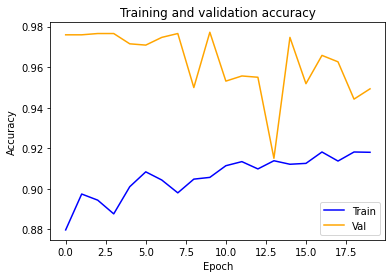

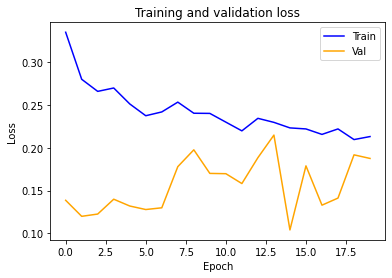

In [16]:
acc = inception_history.history['accuracy']
val_acc = inception_history.history['val_accuracy']
loss = inception_history.history['loss']
val_loss = inception_history.history['val_loss']


plt.title('Training and validation accuracy')
plt.plot(range(epochs), acc, color='blue', label='Train')
plt.plot(range(epochs), val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(epochs), loss, color='blue', label='Train')
plt.plot(range(epochs), val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [17]:
print("Evaluate on test data")
results = inception_model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 7s 166ms/step - loss: 0.5137 - accuracy: 0.7509
test loss, test acc: [0.5136538147926331, 0.7509321570396423]


In [21]:
predictions = inception_model.predict(test_generator)
tumor_prob = predictions[:,1]
y_pred = np.round(tumor_prob)
# y_pred = np.argmax(predictions, axis=-1)
y_true = test_generator.labels

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.78      0.69       840
           1       0.37      0.22      0.28       501

    accuracy                           0.57      1341
   macro avg       0.50      0.50      0.49      1341
weighted avg       0.53      0.57      0.54      1341



## Fine Tuning

In [22]:
base_model.trainable = True
inception_model.summary()

inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 20
inception_history_ft = inception_model.fit(train_generator, 
                              epochs=epochs, 
                              validation_data=validation_generator,
                              callbacks=[inception_early_stop_callback, inception_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 22,360,482
Trainable params: 22,326,050
Non-trainable params: 34,432
_______________________________________

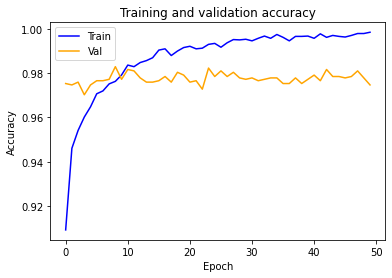

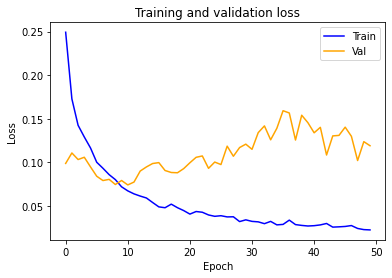

In [26]:
acc = inception_history_ft.history['accuracy']
val_acc = inception_history_ft.history['val_accuracy']
loss = inception_history_ft.history['loss']
val_loss = inception_history_ft.history['val_loss']


plt.title('Training and validation accuracy')
plt.plot(range(epochs), acc, color='blue', label='Train')
plt.plot(range(epochs), val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(range(epochs), loss, color='blue', label='Train')
plt.plot(range(epochs), val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [39]:
best_checkpoint = '/content/checkpoint/Inception/weights-improvement-11-0.98-0.07.hdf5'
inception_model.load_weights(best_checkpoint)

In [40]:
print("Evaluate on test data")
results = inception_model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
42/42 [==============================] - 6s 135ms/step - loss: 0.2304 - accuracy: 0.9202
test loss, test acc: [0.23037154972553253, 0.9202088117599487]


In [41]:
predictions = inception_model.predict(test_generator)
tumor_prob = predictions[:,1]
# y_pred = [1 if prob > 0.8 else 0 for prob in tumor_prob ]
y_pred = np.round(tumor_prob)
# y_pred = np.argmax(predictions, axis=-1)
y_true = test_generator.labels

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.69      0.66       840
           1       0.37      0.30      0.33       501

    accuracy                           0.55      1341
   macro avg       0.50      0.50      0.49      1341
weighted avg       0.53      0.55      0.53      1341



In [45]:
# inception_model.save('/content/inception_model.h5')

# Multi-level Model

In [65]:
print('level 4')
level4_train_generator, level4_validation_generator, level4_test_generator = data_generator_aug(train_image_dir4, 
                                                                                                val_image_dir4, 
                                                                                                test_image_dir4)
print()
print('level 3')
level3_train_generator, level3_validation_generator, level3_test_generator = data_generator_aug(train_image_dir3, 
                                                                                                val_image_dir3, 
                                                                                                test_image_dir3)

level 4
Found 6954 images belonging to 2 classes.
Found 1578 images belonging to 2 classes.
Train data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


Validation data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)
Found 1341 images belonging to 2 classes.

level 3
Found 25760 images belonging to 2 classes.
Found 5855 images belonging to 2 classes.
Train data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


Validation data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)
Found 5070 images belonging to 2 classes.


In [66]:
def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

In [67]:
multi_train_generator = combine_generator(level3_train_generator, level4_train_generator)
multi_val_generator = combine_generator(level3_validation_generator, level4_validation_generator)
multi_test_generator = combine_generator(level3_test_generator, level4_test_generator)

In [96]:
IMG_SIZE = 299
vgg_base_1 = tf.keras.applications.VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            pooling = None,
            classes = 2,
            classifier_activation = 'softmax',
        )
vgg_base_2 = tf.keras.applications.VGG16(
            include_top = False,
            weights = 'imagenet',
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            pooling = None,
            classes = 2,
            classifier_activation = 'softmax',
        )
vgg_base_1.trainable = False
vgg_base_2.trainable = False


high_res_level_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
low_res_level_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# high resolution level
high_res_vgg = tf.keras.Sequential([
    vgg_base_1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu')
])
high_res_vgg_output = high_res_vgg(high_res_level_input)

# low resolution level
low_res_vgg = tf.keras.Sequential([
    vgg_base_2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu')
])
low_res_vgg_output = low_res_vgg(low_res_level_input)

# concatenate two output layers as input
concatenated_input = tf.keras.layers.concatenate([high_res_vgg_output, low_res_vgg_output])
flattened = tf.keras.layers.Flatten()(concatenated_input)

output = tf.keras.layers.Dense(128, activation="relu")(flattened)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.Dense(2, activation="softmax")(output)

vgg_multi_resolution_model = tf.keras.Model(inputs=[high_res_level_input, low_res_level_input], outputs=output)
vgg_multi_resolution_model.summary()

vgg_multi_resolution_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                                   loss = 'sparse_categorical_crossentropy',
                                   metrics = ['accuracy'])

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_71 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 128)          14780352    input_70[0][0]                   
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 128)          14780352    input_71[0][0]                   
___________________________________________________________________________________________

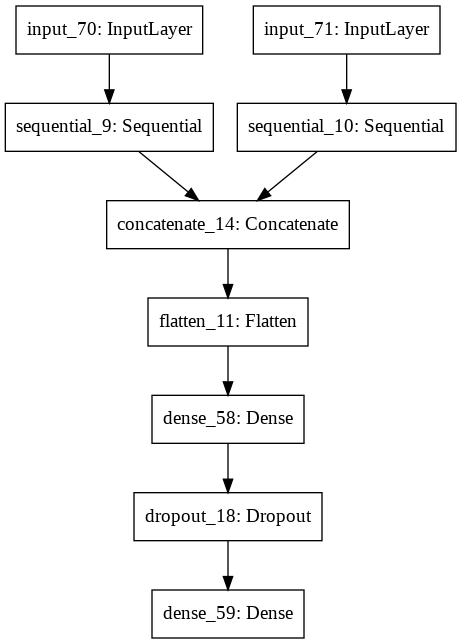

In [97]:
tf.keras.utils.plot_model(vgg_multi_resolution_model)

In [84]:
if not os.path.exists('/content/checkpoint/VGG'):
  os.mkdir('/content/checkpoint/VGG')
multi_vgg_checkpoint_path = '/content/checkpoint/VGG/multi_level_weights-improvement-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'
vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(multi_vgg_checkpoint_path, 
                                                                    monitor='val_loss', 
                                                                    save_best_only=True, 
                                                                    mode='auto')

vgg_early_stop_callback = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=10)

In [93]:
epochs = 10
multi_level_vgg_history = vgg_multi_resolution_model.fit(multi_train_generator, 
                                                          epochs=epochs, 
                                                          validation_data=multi_val_generator,
                                                          callbacks=[vgg_checkpoint_callback, 
                                                                    vgg_early_stop_callback])

Epoch 1/10


ValueError: ignored

# Reconstruct from Predicted Tumor Patches

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
data_path = '/content/drive/MyDrive/Applied Deep Learning/project/data/'

In [ ]:
train_df = pd.read_csv('/content/level4_train_data.txt', header=None)
train_df.columns = ['Image Paths', 'Mask Paths', 'Xoffset', 'Yoffset', 'Labels', 'Level','Slide Code']

test_df = pd.read_csv('/content/level4_test_data.txt', header=None)
test_df.columns = ['Image Paths', 'Mask Paths', 'Xoffset', 'Yoffset', 'Labels', 'Level','Slide Code']

In [ ]:
slide_code = '016'
slide_name = f'slide{slide_code}'
slide_df = test_df.iloc[list(map(lambda x: slide_name in x, test_df['Image Paths'])),:]
slide_df['test_image'] = slide_df['Image Paths'].map(lambda x:'/'.join(x.split('/')[-2:]))

slide_test_info = [(i, path) for i, path in enumerate(test_path_list) if slide_name in path]
slide_test_path = [path for i, path in slide_test_info]
slide_test_idx = [i for i, path in slide_test_info]
slide_test_tumor_prob = [tumor_prob[i] for i in slide_test_idx]
slide_test_result_df = pd.DataFrame({'path': slide_test_path, 'prob': slide_test_tumor_prob})
merge_df = pd.merge(slide_df, slide_test_result_df, how='left', left_on='test_image', right_on = 'path')

In [ ]:
slide_path = data_path + 'tumor_%s.tif' %slide_code
tumor_mask_path = data_path + 'tumor_%s_mask.tif' %slide_code
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [ ]:
img_pred = Image.new('RGB', slide.level_dimensions[5])
img_true = Image.new('RGB', slide.level_dimensions[5])

patches_paths = [test_image_dir +'/' + path for path in merge_df['path'].to_list()]
mask_paths = [path.replace('level4/','') for path in merge_df['Mask Paths'].to_list()]
offsets = zip(merge_df.Xoffset.to_list(), merge_df.Yoffset.to_list())
labels = merge_df.Labels.to_list()
probs = merge_df.prob.to_list()

for patch_path, mask_path, offset, label, prob in zip(patches_paths, mask_paths, offsets, labels, probs):
    if prob > 0.5:
      patch = Image.open(patch_path)
      patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
      mask = Image.open(mask_path)
      mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (0, 0, 0, 0)), 0.5)
      img_pred.paste(patch, box=offset)
      img_pred.paste(mask, box=offset)
    # if label > 0:
    #   patch = Image.open(patch_path)
    #   patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
    #   mask = Image.open(mask_path)
    #   mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (192, 192, 192, 3)), 0.5)
    #   img_true.paste(patch, box=offset)
    #   img_true.paste(mask, box=offset)
    else:
      patch = Image.open(patch_path)
      patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
      img_true.paste(patch, box=offset)

In [ ]:
img_true.resize(map(lambda x: int(x / 8), img.size))

In [ ]:
img_pred.resize(map(lambda x: int(x / 8), img.size))